# electricity_market_player

> Fill in a module description here

In [ ]:
#| default_exp electricity_market_player

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import matplotlib.pyplot as plt
import numpy as np
import optuna
import seaborn as sns

from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.common.maskable.evaluation import evaluate_policy
from scipy import stats
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from rliable import metrics, plot_utils, library as rly

from electricity_market.electricity_market_env import ElectricityMarketEnv


In [ ]:
#| export
def collect_episode_rewards(model, env, n_episodes=10, deterministic=True):
    episode_rewards, _ = evaluate_policy(
        model, env, deterministic=deterministic, use_masking=True,
        return_episode_rewards=True, n_eval_episodes=n_episodes
    )
    return episode_rewards


def mask_fn(env):
    return env.action_masks()

TOTAL_TIMESTEPS = 100
N_EPISODES = 5
N_TRAILS = 5
seeds = [123456, 234567, 345678, 456789, 567890]
if TOTAL_TIMESTEPS % N_EPISODES != 0:
    raise ValueError("Total_timesteps must be a multiple of n_episodes")
frames = np.array(list(range(TOTAL_TIMESTEPS // N_EPISODES, TOTAL_TIMESTEPS + 1, TOTAL_TIMESTEPS // N_EPISODES)), dtype=int)
env_config = {
    "max_timestep": TOTAL_TIMESTEPS,
}
results = {}

In [ ]:
#| export
def evaluate_maskable_ppo_on_environment(hyperparameters=None, n_episodes=N_EPISODES):
    global seeds, frames, env_config

    if hyperparameters is None:
        hyperparameters = {}
    all_rewards = []

    for seed in seeds:
        print(f"\nRunning experiment with seed {seed}...")
        env = DummyVecEnv([
            lambda: Monitor(ActionMasker(ElectricityMarketEnv(env_config), mask_fn))
        ])

        model = MaskablePPO(
            MaskableActorCriticPolicy,
            env,
            verbose=0,
            seed=seed,
            **hyperparameters
        )

        seed_rewards = []

        for frame in frames:
            model.learn(total_timesteps=frame, use_masking=True, reset_num_timesteps=False)
            rewards = collect_episode_rewards(model, env, n_episodes=n_episodes, deterministic=True)
            seed_rewards.append(rewards)

        seed_rewards = np.array(seed_rewards)  # Shape: (num_checkpoints, num_episodes)
        all_rewards.append(seed_rewards)

    all_rewards = np.array(all_rewards)  # Shape: (num_seeds, num_checkpoints, num_episodes)
    print("\nCollected Rewards (shape: seeds x checkpoints x episodes):\n", all_rewards)
    return all_rewards

In [ ]:
#| export
def plot_evaluation_results(evaluation_results):
    global seeds, frames, env_config
    # Extract algorithm names (which are actually keys in the dictionary)
    algorithms = list(evaluation_results.keys())

    # Function to compute aggregate metrics (median, IQM, mean) for each checkpoint and seed
    def aggregate_func(x):
        return np.array([
            metrics.aggregate_median(x),
            metrics.aggregate_iqm(x),
            metrics.aggregate_mean(x),
        ])

    # For each algorithm, we need to apply aggregate_func to the data (which has the shape (num_seeds, num_checkpoints, num_episodes))
    def aggregate_over_checkpoints(evaluation_results):
        aggregated_results = {}
        for algorithm, results in evaluation_results.items():
            # results.shape is (num_seeds, num_checkpoints, num_episodes)
            # We aggregate across seeds and episodes for each checkpoint
            agg_results = np.array([aggregate_func(results[:, i, :]) for i in range(results.shape[1])])
            aggregated_results[algorithm] = agg_results
        return aggregated_results

    # Aggregate results across seeds and episodes
    aggregated_results = aggregate_over_checkpoints(evaluation_results)

    # Use rly to compute interval estimates
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        aggregated_results, aggregate_func, reps=50000
    )

    # Plot aggregate metrics (Median, IQM, Mean)
    metric_names = ['Median', 'IQM', 'Mean']
    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores,
        aggregate_score_cis,
        metric_names=metric_names,
        algorithms=algorithms,
        xlabel='Reward'
    )
    fig.set_size_inches(10, 5)
    plt.suptitle("Aggregate Metrics with 95% Stratified Bootstrap CIs", y=1.05, fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.show()

    # =============================================================================
    # 2. Probability of Improvement (if comparing two algorithms)
    # =============================================================================
    if len(algorithms) == 2:
        alg1, alg2 = algorithms
        algorithm_pairs = {f"{alg1},{alg2}": (evaluation_results[alg1], evaluation_results[alg2])}

        average_probabilities, average_prob_cis = rly.get_interval_estimates(
            algorithm_pairs, metrics.probability_of_improvement, reps=2000
        )

        plot_utils.plot_probability_of_improvement(average_probabilities, average_prob_cis)
        plt.title(f"Probability of Improvement: {alg1} vs {alg2}", pad=20)
        plt.show()

    # =============================================================================
    # 3. Sample Efficiency Curve (using frames as defined in the evaluation function)
    # =============================================================================
    sample_efficiency_dict = {
        alg: results[:, 1:, :]  # We want to remove the first checkpoint as it's usually 0
        for alg, results in evaluation_results.items() if len(results.shape) == 3
    }

    # Define the IQM function
    iqm_func = lambda scores: np.array([metrics.aggregate_iqm(scores[:, :, frame]) for frame in range(scores.shape[2])])

    # Compute IQM scores and confidence intervals using rly
    iqm_scores, iqm_cis = rly.get_interval_estimates(sample_efficiency_dict, iqm_func, reps=50000)
    # Plot the sample efficiency curve
    plot_utils.plot_sample_efficiency_curve(
        frames=frames + 1,  # Adjust frames if necessary
        point_estimates=iqm_scores,
        interval_estimates=iqm_cis,
        algorithms=sample_efficiency_dict.keys(),
        xlabel='Number of Frames',
        ylabel='IQM Reward'
    )
    plt.title("Sample Efficiency Curve")
    plt.show()


    # =============================================================================
    # 4. Performance Profiles (linear and non-linear scaling)
    # =============================================================================
    thresholds = np.linspace(0.0, 8.0, 81)
    score_distributions, score_distributions_cis = rly.create_performance_profile(
        evaluation_results, thresholds
    )

    # Plot performance profiles with linear scale
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
        xlabel=r'Normalized Score $(\tau)$',
        ax=ax
    )
    plt.title("Performance Profiles (Linear Scale)")
    plt.show()

    # Plot performance profiles with non-linear scaling
    thresholds = np.logspace(-1, 0, num=50)
    fig, ax = plt.subplots(ncols=1, figsize=(7, 5))
    plot_utils.plot_performance_profiles(
        score_distributions,
        thresholds,
        performance_profile_cis=score_distributions_cis,
        use_non_linear_scaling=True,
        colors=dict(zip(algorithms, sns.color_palette('colorblind'))),
        xlabel=r'Normalized Score $(\tau)$',
        ax=ax
    )
    # ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    plt.title("Performance Profiles (Non-Linear Scaling)")
    plt.tight_layout()
    plt.show()



In [ ]:
#| export
def optimize_maskable_ppo_agent(trial, n_episodes=N_EPISODES):
    global seeds
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    n_steps = trial.suggest_int('n_steps', 16, 2048, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 256, log=True)

    trial_seed_rewards = []

    for seed in seeds:
        env = DummyVecEnv([
            lambda: Monitor(ActionMasker(ElectricityMarketEnv(env_config), mask_fn))
        ])

        model = MaskablePPO(
            MaskableActorCriticPolicy,
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            batch_size=batch_size,
            verbose=0,
            seed=seed
        )

        model.learn(total_timesteps=10_000, use_masking=True)
        episode_rewards = collect_episode_rewards(model, env, n_episodes=n_episodes, deterministic=True)

        seed_avg_reward = np.mean(episode_rewards)
        trial_seed_rewards.append(seed_avg_reward)
    aggregated_performance = stats.trim_mean(trial_seed_rewards, proportiontocut=0.25)

    return aggregated_performance

### Evaluation MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
results["MaskablePPO_Baseline"] = evaluate_maskable_ppo_on_environment(hyperparameters=None, n_episodes=N_EPISODES)


Running experiment with seed 123456...

Running experiment with seed 234567...

Running experiment with seed 345678...

Running experiment with seed 456789...

Running experiment with seed 567890...

Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[176361.207226 157333.740665 176164.638614 165098.889074 170673.428694]
  [182126.218    169050.607458 183594.691595 189143.490712 197711.884312]
  [175647.84862  179879.440733 191639.239185 193128.81401  184729.138287]
  [186282.724193 166438.505772 170097.363023 180106.33666  190962.26568 ]
  [186209.652861 183189.739144 171212.511813 180357.644539 169764.645834]]

 [[128875.313762 129255.226145 130866.933885 135977.540872 141523.857779]
  [127688.057268 127415.137742 127947.096341 125595.72206  129109.467342]
  [128090.457052 137897.015156 132596.505438 130319.644117 127363.805346]
  [126732.106468 137610.952963 134607.470464 131424.925514 120228.339363]
  [125111.423955 123908.651962 121054.661595 127319.046953 125732.13450

### Hypertuning MaskablePPO with default hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
study = optuna.create_study(direction="maximize")
study.optimize(optimize_maskable_ppo_agent, n_trials=N_TRAILS)

print("Best trial:", study.best_trial)

[I 2025-02-09 22:27:12,197] A new study created in memory with name: no-name-df346974-e6a9-450c-81f9-387d7e40c9eb
[I 2025-02-09 22:27:39,438] Trial 0 finished with value: 148457.34998179998 and parameters: {'learning_rate': 0.007891706812011024, 'n_steps': 824, 'batch_size': 51}. Best is trial 0 with value: 148457.34998179998.
[I 2025-02-09 22:28:04,363] Trial 1 finished with value: 83433.15714206667 and parameters: {'learning_rate': 1.88246633684239e-05, 'n_steps': 115, 'batch_size': 100}. Best is trial 0 with value: 148457.34998179998.
[I 2025-02-09 22:28:28,289] Trial 2 finished with value: 159914.12927206667 and parameters: {'learning_rate': 0.005936009321637813, 'n_steps': 136, 'batch_size': 75}. Best is trial 2 with value: 159914.12927206667.
[I 2025-02-09 22:28:58,032] Trial 3 finished with value: 116077.80734059999 and parameters: {'learning_rate': 0.0010320793361513795, 'n_steps': 141, 'batch_size': 39}. Best is trial 2 with value: 159914.12927206667.
[I 2025-02-09 22:29:23,36

Best trial: FrozenTrial(number=2, state=1, values=[159914.12927206667], datetime_start=datetime.datetime(2025, 2, 9, 22, 28, 4, 363797), datetime_complete=datetime.datetime(2025, 2, 9, 22, 28, 28, 289536), params={'learning_rate': 0.005936009321637813, 'n_steps': 136, 'batch_size': 75}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'n_steps': IntDistribution(high=2048, log=True, low=16, step=1), 'batch_size': IntDistribution(high=256, log=True, low=16, step=1)}, trial_id=2, value=None)


### Evaluation MaskablePPO with optimized hyperparameters on ElectricityMarketEnv

In [ ]:
#| export
results["MaskablePPO_Optimized"] = evaluate_maskable_ppo_on_environment(hyperparameters=study.best_trial.params, n_episodes=N_EPISODES)


Running experiment with seed 123456...

Running experiment with seed 234567...

Running experiment with seed 345678...

Running experiment with seed 456789...

Running experiment with seed 567890...

Collected Rewards (shape: seeds x checkpoints x episodes):
 [[[ 15468.831665  14951.038695  15477.001978  12883.965412  15015.683635]
  [-16936.456917 -10388.559193 -18512.160284 -17222.411704 -16184.442964]
  [ 15258.324295  15628.038739  15463.478521  15755.502236  16306.937082]
  [ 62933.043796  81260.617239  63856.702983  64464.774087 124036.352744]
  [103730.173172 106530.072173 107509.147156 101798.79863  106830.614711]]

 [[-26410.961142  -9366.578832  -4430.213301 -18151.489114 -10138.217251]
  [-25837.427071 -16804.259636 -22263.274131 -19598.616429 -26855.35008 ]
  [-30864.347182 -33531.229566 -31897.671674 -26667.960497 -41059.210902]
  [113567.074594  87191.989934 130817.726719 125813.40009  129515.844853]
  [152345.53646  146351.353258 142176.238941 154492.390531 149455.58445

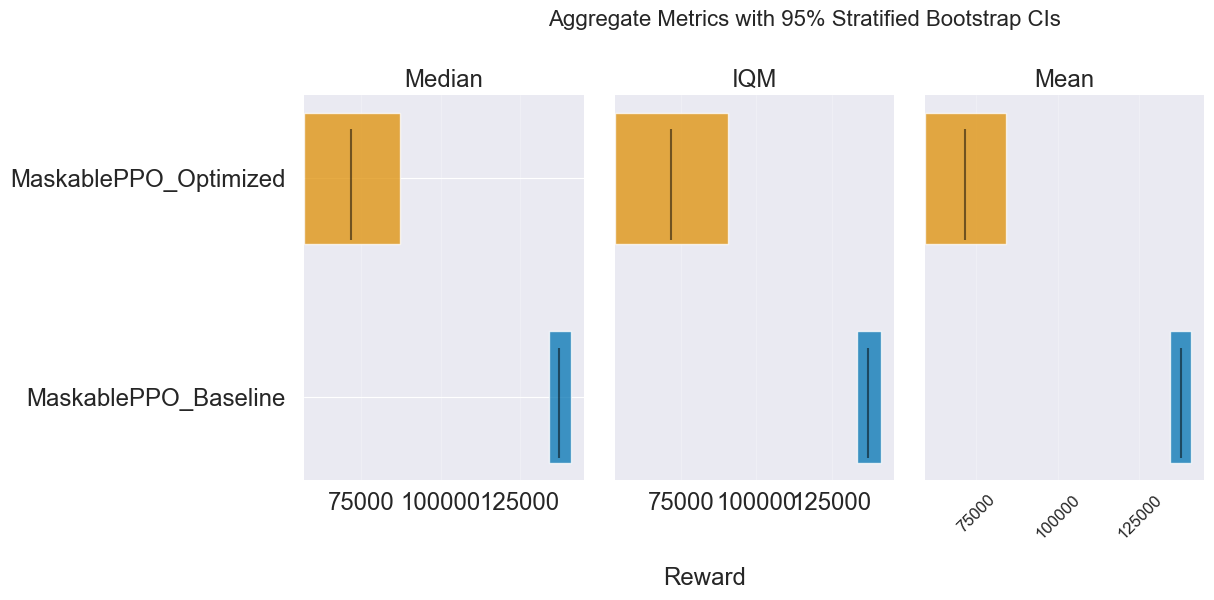

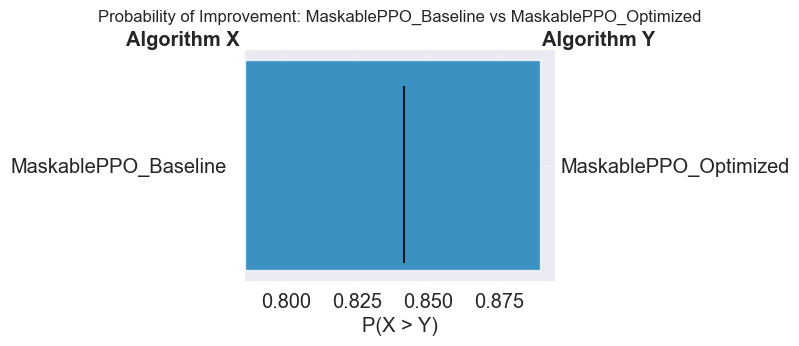

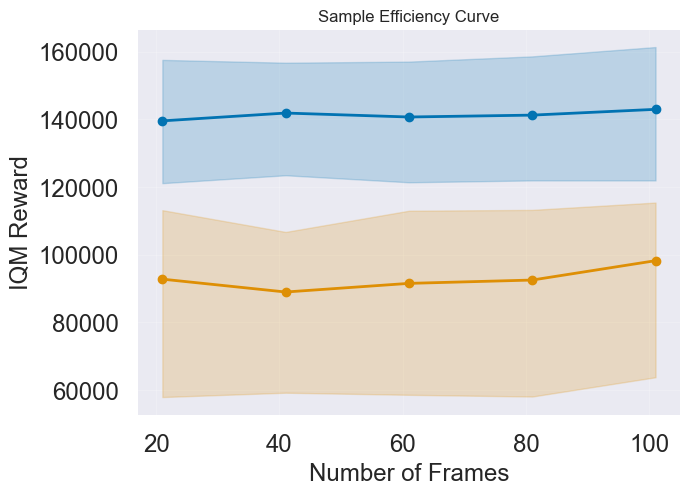

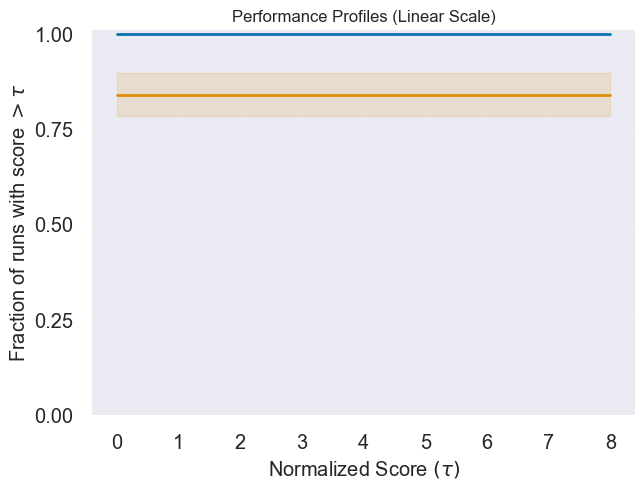

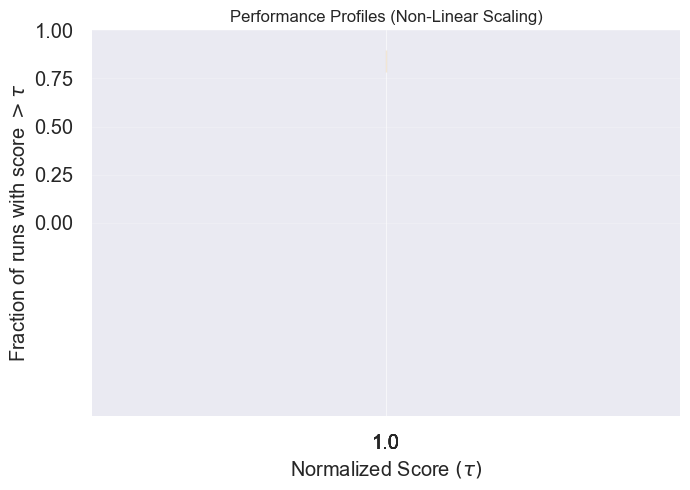

In [ ]:
#| export
plot_evaluation_results(results)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()